# CB-VAE: Theory

For notes on the standard VAE please refer to the [[VAE](https://github.com/udeepam/vae/blob/master/notebooks/vae.ipynb)].

**Notation**
* Observed variables $\mathbf{x}\in\mathcal{X}=[0,1]^{D}$
* Unobserved latent variables $\mathbf{z}\in\mathcal{Z}=\mathbb{R}^{k}$
* Dataset $\mathcal{D}=\{\mathbf{x}_i\}^{n}_{i=1}$

### The Problem with standard VAE

The Continuous-Bernoulli VAE is very similar to the standard VAE. In the standard VAE we model the decoder as an independent Bernoulli for each element $x_j$ of $\mathbf{x}$
$$p_\theta(\mathbf{x}\mid\mathbf{z})=\text{Ber}\Big(\lambda_\theta(\mathbf{z})\Big)$$
where $\lambda_\theta: \mathbb{R}^{k}\rightarrow[0,1]^{D}$. Let $\text{Ber}(\lambda)$ denote the product of $D$ independent Bernoulli distributions, with parameters $\lambda\in[0,1]^{D}$. By using this parameterisation of the decoder the reconstruction term in the ELBO is given as
$$-\log p_\theta(\mathbf{x}_i\mid \mathbf{z}_i)=-\Big[\sum^{D}_{j=1}x_j\log \hat{x}_j + (1-x_j)\log(1-\hat{x}_j)\Big]$$
where $\hat{\mathbf{x}}=\lambda_\theta(\mathbf{z})$. This is the Binary Cross Entropy loss.

The problem here is that Bernoulli likelihoods should only be used for binary data where $\mathbf{x}\in\{0,1\}^{D}$. However they are commonly used for $[0,1]$-valued data, which loses the interpretation of probabilistic inference as the distribution is then unnormalised. We denote the Bernoulli distribution as $\tilde{p}(x|\lambda)= \lambda^{x}(1 − \lambda)^{1−x}$ to emphasize the fact that it is an unnormalized distribution (when evaluated over $[0,1]$). We

### Continuous Bernoulli VAE

The continuous Bernoulli, a novel distribution on $[0,1]$, which is parameterized by $\lambda\in(0,1)$ and defined by
$$X\sim\text{CBer}(\lambda)\Leftrightarrow p(x|\lambda)\propto\tilde{p}(x|\lambda)=\lambda^{x}(1 − \lambda)^{1−x}$$

Hence in the CB-VAE we model the decoder as an independent Continuous Bernoulli for each element $x_j$ of $\mathbf{x}$
$$p_\theta(\mathbf{x}\mid\mathbf{z})=\text{CBer}\Big(\lambda_\theta(\mathbf{z})\Big)$$
where $\lambda_\theta: \mathbb{R}^{k}\rightarrow[0,1]^{D}$. Let $\text{CBer}(\lambda)$ denote the product of $D$ independent Continuous Bernoulli distributions, with parameters $\lambda\in[0,1]^{D}$.

Operationally, this modification results only in a change to the optimized objective such that
$$-\log p_\theta(\mathbf{x}_i\mid \mathbf{z}_i)=-\Big[\sum^{D}_{j=1}x_j\log \hat{x}_j + (1-x_j)\log(1-\hat{x}_j)+\log C(\hat{x}_j)\Big]$$
where $C(\lambda)$ is given by 
$$C(\lambda)=\begin{cases}
\frac{2\text{tanh}^{-1}(1-2\lambda)}{1-2\lambda} & \text{ if }\lambda\neq0.5\\
2 & \text{ otherwise}
\end{cases}$$

The complete loss function to minimise is given as
$$\mathcal{L}(\mathbf{x},\theta,\phi)\approx \frac{1}{n}\sum^{n}_{i=1}\Bigg[\frac{1}{2}\sum^{k}_{j=1}\Big[\mu^{2}_{\phi,j}(\mathbf{x}_i)+\sigma^{2}_{\phi,j}(\mathbf{x}_i)-\log\sigma^{2}_{\phi,j}(\mathbf{x}_i)-1\Big]-\log p_\theta(\mathbf{x}_i\mid\mathbf{z}_{i})\Bigg]$$
where 
* $\mathbf{z}_{i}=g_\phi\Big(\mathbf{x}_i,\boldsymbol{\epsilon}_{i}\Big)=\boldsymbol{\mu}_{\phi}(\mathbf{x}_i)+\boldsymbol{\sigma}_{\phi}(\mathbf{x}_i)\odot \boldsymbol{\epsilon}_{i}$ and $\boldsymbol{\epsilon}_{i}\sim\mathcal{N}(\mathbf{0},\mathbf{I}_k)$

* the gradients w.r.t. $\theta$ and $\phi$ can be computed using automatic differentiation and they are unbiased estimates.

# CB-VAE: Code

PyTorch-VAE: https://github.com/AntixK/PyTorch-VAE<br>
https://github.com/ethanluoyc/pytorch-vae

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
np.random.seed(seed)

## Load MNIST Dataset

In [2]:
# import torchvision
# from torchvision import transforms
# from torchvision.datasets import MNIST
# # 60000 tuples with 1x28x28 image and corresponding label
# data = MNIST('../data', 
#              train=True, 
#              download=True,
#              transform = transforms.Compose([transforms.ToTensor()]))
# # Split data into images and labels
# x_train = data.train_data
# y_train = data.train_labels
# # Scale images from [0,255] to [0,+1]
# x_train = x_train.float() / 255
# # Save as .npz
# np.savez_compressed('../data/mnist', 
#                     a=x_train,
#                     b=y_train)

In [3]:
# Load MNIST data locally
data = np.load('../data/mnist.npz')
x_train = torch.Tensor(data['a'])
y_train = torch.Tensor(data['b'])
n_classes = len(np.unique(y_train))

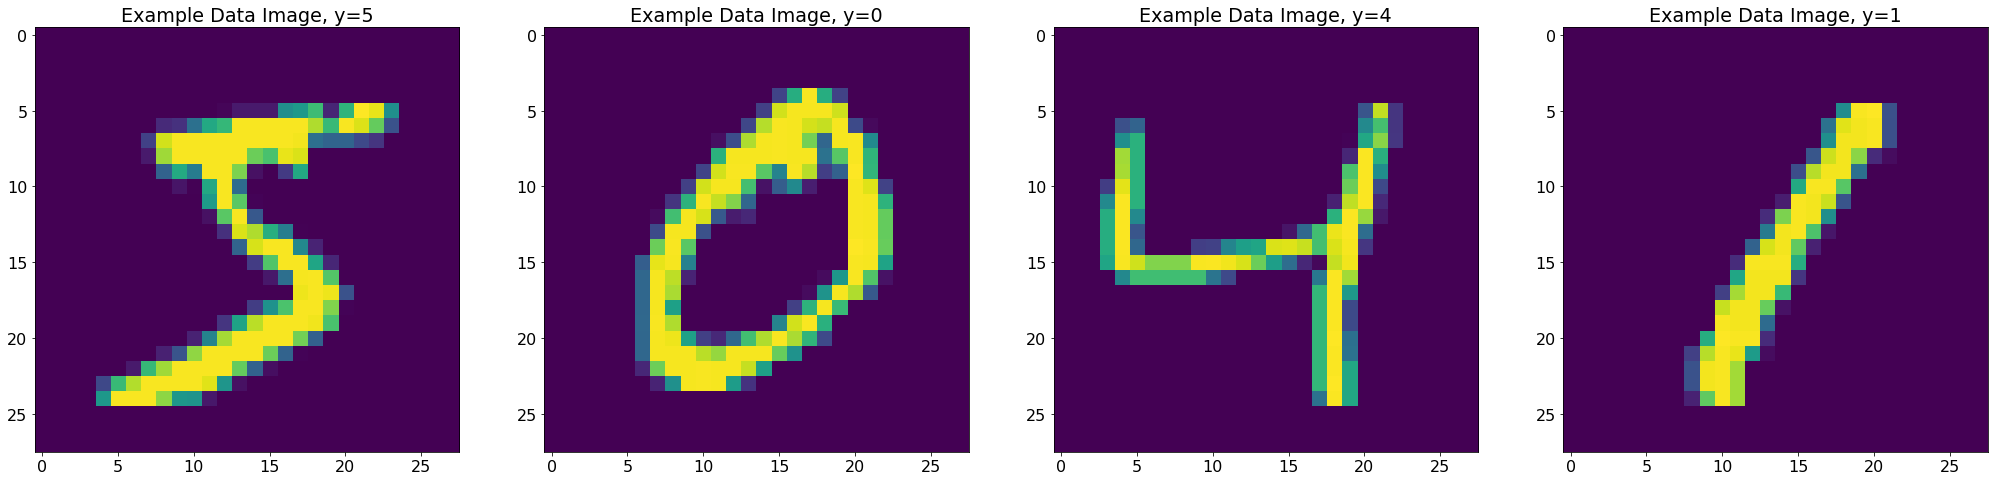

In [4]:
# Visualise data
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1,4, figsize=(35,35))
imx, imy = (28,28)
labels   = [0,1,2,3]
for i, ax in enumerate(axes):
    visual = np.reshape(x_train[labels[i]], (imx,imy))
    ax.set_title("Example Data Image, y="+str(int(y_train[labels[i]])))
    ax.imshow(visual, vmin=0, vmax=1)
plt.show()

## Models

In [5]:
class VanillaVAE(nn.Module):
    def __init__(self, input_shape, z_dim):
        """
        Vanilla VAE Model.
        
        Arguments:
        ----------
        input_shape : `int`
            Flattened size of image. (Default=784)
        z_dim : `int`
            The dimension of the latent variable z. (Default=20)
        """        
        super(VanillaVAE, self).__init__()
        self.input_shape = input_shape
        self.z_dim  = z_dim
        
        # build encoder
        self.encoder = nn.Sequential(nn.Linear(input_shape, 400),
                                     nn.ReLU(inplace=True))  
        self.fc_mu = nn.Linear(400, self.z_dim) 
        self.fc_log_var = nn.Linear(400, self.z_dim)
        
        # build decoder
        self.decoder = nn.Sequential(nn.Linear(self.z_dim, 400),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(400, input_shape))          

    def encode(self, x):
        """
        x : [batch_size,784]
        """
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_log_var(x)
    
    def decode(self, z):
        """
        z : [batch_size,z_dim]
        """        
        return torch.sigmoid(self.decoder(z))
    
    def reparameterise(self, mu, log_var):
        """
        mu : [batch_size,z_dim]
        log_var : [batch_size,z_dim]        
        """        
        # get standard deviation
        std = torch.exp(0.5*log_var)
        # get epsilon from standard normal
        eps = torch.randn_like(std)
        return mu + std*eps
    
    def forward(self, x):
        """
        Forward pass 
        
        Parameters:
        -----------
        x : [batch_size,28,28]
        """
        # flattent image
        x_flat = x.view(x.size(0), -1)
        mu, log_var = self.encode(x_flat)
        z = self.reparameterise(mu, log_var)
        return self.decode(z), mu, log_var
    
    
    def sample(self, num_samples):
        """
        Sample from the latent and return corresponding image space map.
        
        num_samples : `int`
        """
        z = torch.randn(num_samples, z_dim)
        z = z.to(device)
        samples = self.decode(z)
        return samples.detach().cpu().numpy()       

## Training

In [6]:
# Hyperparameters
z_dim  = 20
epochs = 200
batch_size = 128
learning_rate = 1e-3
num_samples = 10

In [7]:
# Create DatatLoader 
dataset    = data_utils.TensorDataset(x_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

# def sumlogC1(x , l_lim=0.49, u_lim=0.51, eps=1e-5):
#     """
#     Numerically stable implementation of sum of logarithm of Continuous Bernoulli constant C
#     Returns log normalising constant for x in (0, x-eps) and (x+eps, 1)
#     Uses Taylor 3rd degree approximation in [x-eps, x+eps].
        
#     Parameter
#     ----------
#     x : `torch.Tensor`
#         Tensor of dimensions (batch_size, dim). 
#         x takes values in (0,1)
#     """
#     x = torch.clamp(x, eps, 1.-eps) 
#     cut_x = torch.where(torch.logical_or(x.le(l_lim), x.ge(u_lim)), x, l_lim * torch.ones_like(x))
#     log_norm = torch.log(torch.abs(2.*torch.atanh(1-2.*cut_x))) - torch.log(torch.abs(1-2.*cut_x)) 
#     taylor = torch.log(torch.tensor(2.)) + 4./3.*(x - 0.5).pow(2) + 104./45.*(x - 0.5).pow(4)
#     return torch.where(torch.logical_or(x.le(l_lim), x.ge(u_lim)), log_norm, taylor).sum()

def sumlogC(x , eps=1e-5):
    """
    Numerically stable implementation of sum of logarithm of Continuous Bernoulli constant C
    Returns log normalising constant for x in (0, x-eps) and (x+eps, 1)
    Uses Taylor 3rd degree approximation in [x-eps, x+eps].
        
    Parameter
    ----------
    x : `torch.Tensor`
        Tensor of dimensions (batch_size, dim). 
        x takes values in (0,1)
    """
    # clip x such that x in (0, 1)
    x = torch.clamp(x, eps, 1.-eps) 
    # get mask if x is not in [0.5-eps, 0.5+eps]
    mask = torch.abs(x - .5).ge(eps)
    # points that are (0, 0.5-eps) and (0.5+eps, 1)
    far = x[mask]
    # points that are [0.5-eps, 0.5+eps]     
    close = x[~mask]
    # Given by log(|2tanh^-1(1-2x)|) - log(|1-2x|)   
    far_values = torch.log(torch.abs(2.*torch.atanh(1-2.*far))) - torch.log(torch.abs(1-2.*far)) 
    # using Taylor expansion to 3rd degree
    close_values = torch.log(2. + (1-2*close).pow(2)/3 + (1-2*close).pow(4)/5)   
    return far_values.sum() + close_values.sum()

# Loss function: Binary Cross Entropy Loss (BCE) + KL divergence
def loss_function(recon_x, x, mu, log_var):
    """    
    recon_x : [batch_size,784]
    x : [batch_size,28,28]    
    mu : [batch_size,z_dim]  
    log_var: [batch_size,z_dim] 
    """   
    BCE  = F.binary_cross_entropy(recon_x, x.view(x.size(0), -1), reduction='sum') 
    logC = sumlogC(recon_x)
    KL   = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - log_var - 1)
    return (KL + BCE - logC) / x.size(0)

# Initialize VAE
vae = VanillaVAE(np.prod(x_train[0].shape), z_dim)

# Optimisers
optimiser = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Send to GPU if available
vae.to(device)

print("Device: ", device)
print(vae)

Device:  cuda
VanillaVAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc_log_var): Linear(in_features=400, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=784, bias=True)
  )
)


In [8]:
# Training
measures = defaultdict(list)
start_time = time.time()

# put VAE into train mode 
vae.train() 

for epoch in range(epochs):
    epoch_start_time = time.time()      
    
    batch_loss = 0
    for _, (X,_) in enumerate(dataloader): 
        X = X.to(device)
            
        # Zero accumulated gradients
        vae.zero_grad()
        
        # forward pass through VAE
        recon_batch, mu, log_var = vae(X)
        
        # Calculate loss
        loss = loss_function(recon_batch, X, mu, log_var)
        # Backpropogation: calculating gradients
        loss.backward()
        # Update parameters of generator
        optimiser.step()  
        
        # Save loss per batch
        batch_loss += loss.item()*X.size(0)                  
           
    # Save losses per epoch
    measures['total_loss'].append(batch_loss / len(dataloader.dataset))    
    
    # Save images produced every epoch
    if epoch==0 or (epoch+1)%4==0:
        indices = np.random.randint(0,X.size(0),n_classes)
        measures['true_images'].append(X[indices].detach().cpu().numpy()) 
        measures['recon_images'].append(recon_batch[indices].detach().cpu().numpy())      
    
    print("Epoch: {}/{}...".format(epoch+1, epochs),
          "Loss: {:.4f}...".format(measures['total_loss'][-1]),
          "Time Taken: {:,.4f} seconds".format(time.time()-epoch_start_time))
    
print("Total Time Taken: {:,.4f} seconds".format(time.time()-start_time))

Epoch: 1/200... Loss: -1311.9528... Time Taken: 4.8527 seconds
Epoch: 2/200... Loss: -1520.4171... Time Taken: 4.8100 seconds
Epoch: 3/200... Loss: -1562.0130... Time Taken: 4.6961 seconds
Epoch: 4/200... Loss: -1581.1985... Time Taken: 5.7607 seconds
Epoch: 5/200... Loss: -1591.6604... Time Taken: 4.8393 seconds
Epoch: 6/200... Loss: -1598.4417... Time Taken: 5.7751 seconds
Epoch: 7/200... Loss: -1603.1899... Time Taken: 5.3121 seconds
Epoch: 8/200... Loss: -1606.9300... Time Taken: 4.9185 seconds
Epoch: 9/200... Loss: -1609.9185... Time Taken: 4.8005 seconds
Epoch: 10/200... Loss: -1612.1999... Time Taken: 5.7489 seconds
Epoch: 11/200... Loss: -1614.0798... Time Taken: 5.7612 seconds
Epoch: 12/200... Loss: -1615.6557... Time Taken: 5.7518 seconds
Epoch: 13/200... Loss: -1617.0913... Time Taken: 5.7706 seconds
Epoch: 14/200... Loss: -1618.3410... Time Taken: 4.7920 seconds
Epoch: 15/200... Loss: -1619.3384... Time Taken: 4.8026 seconds
Epoch: 16/200... Loss: -1620.2637... Time Taken: 

Epoch: 129/200... Loss: -1636.0177... Time Taken: 5.1237 seconds
Epoch: 130/200... Loss: -1636.1465... Time Taken: 4.7588 seconds
Epoch: 131/200... Loss: -1636.1361... Time Taken: 5.5457 seconds
Epoch: 132/200... Loss: -1636.2127... Time Taken: 4.9070 seconds
Epoch: 133/200... Loss: -1636.1757... Time Taken: 4.7967 seconds
Epoch: 134/200... Loss: -1636.3093... Time Taken: 5.6524 seconds
Epoch: 135/200... Loss: -1636.3061... Time Taken: 4.7990 seconds
Epoch: 136/200... Loss: -1636.3242... Time Taken: 4.8205 seconds
Epoch: 137/200... Loss: -1636.3814... Time Taken: 4.8630 seconds
Epoch: 138/200... Loss: -1636.3863... Time Taken: 4.7924 seconds
Epoch: 139/200... Loss: -1636.4161... Time Taken: 5.0214 seconds
Epoch: 140/200... Loss: -1636.5155... Time Taken: 5.0100 seconds
Epoch: 141/200... Loss: -1636.4626... Time Taken: 5.0405 seconds
Epoch: 142/200... Loss: -1636.5773... Time Taken: 4.7631 seconds
Epoch: 143/200... Loss: -1636.5831... Time Taken: 5.0403 seconds
Epoch: 144/200... Loss: -

## Results

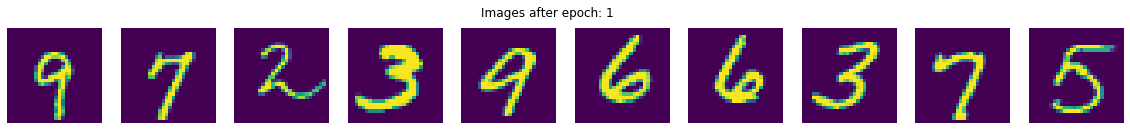

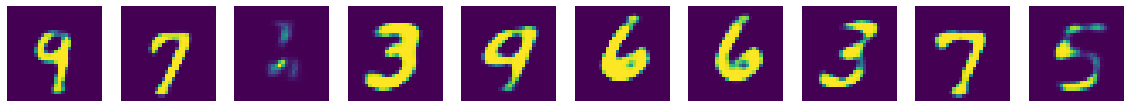

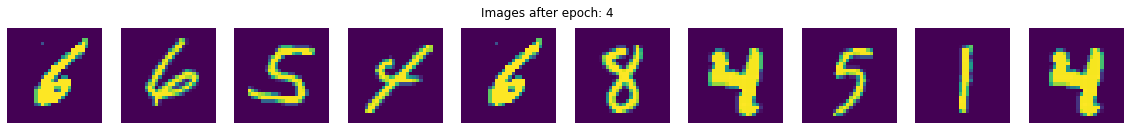

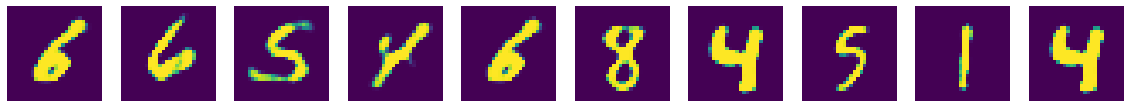

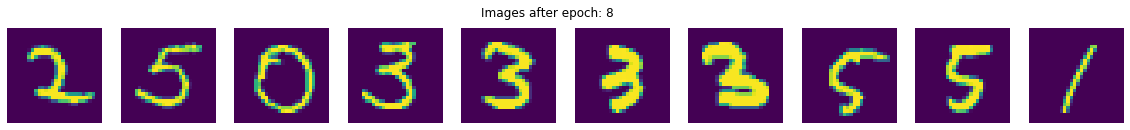

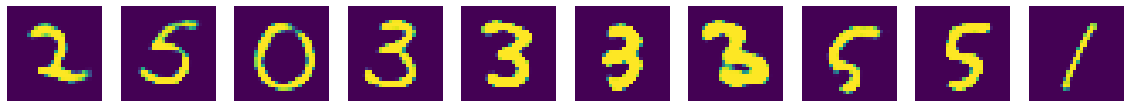

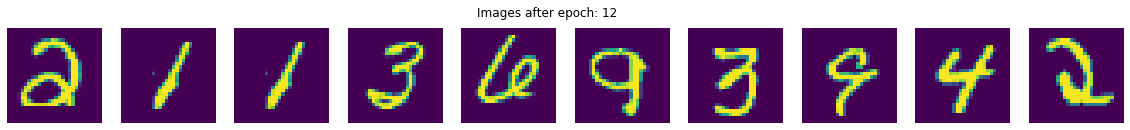

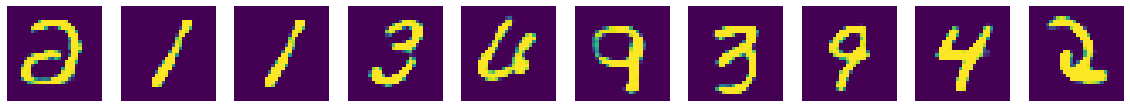

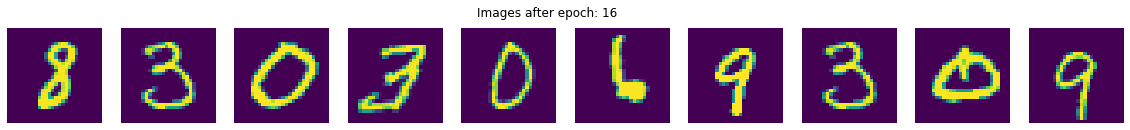

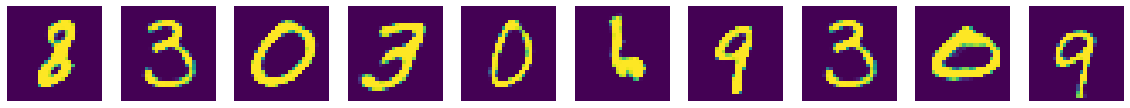

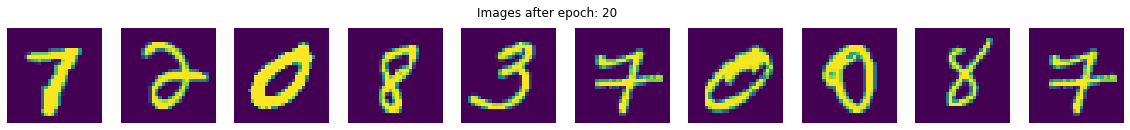

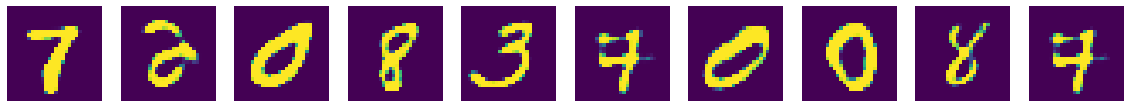

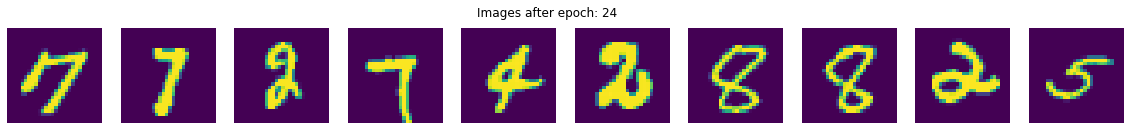

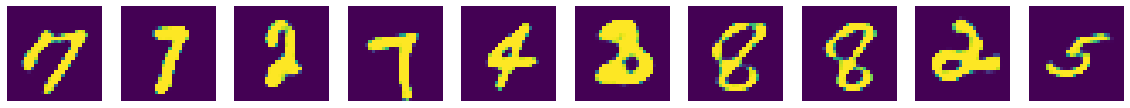

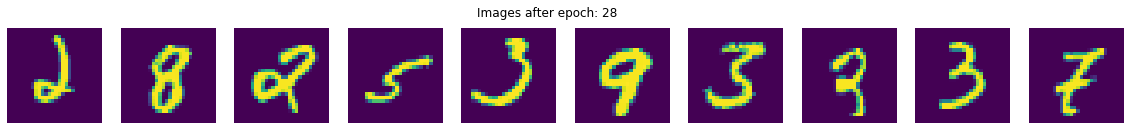

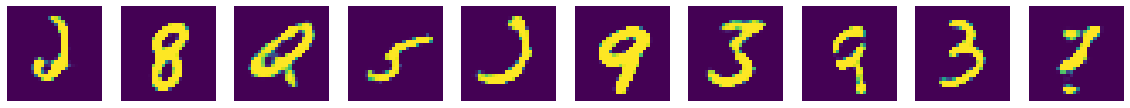

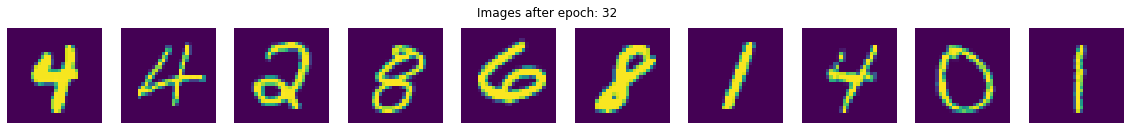

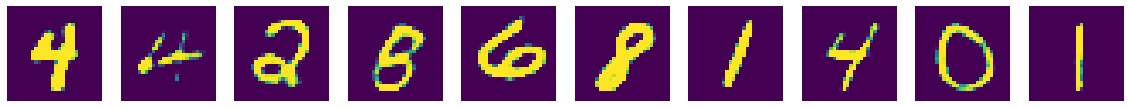

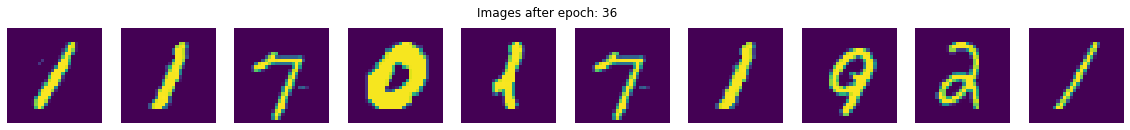

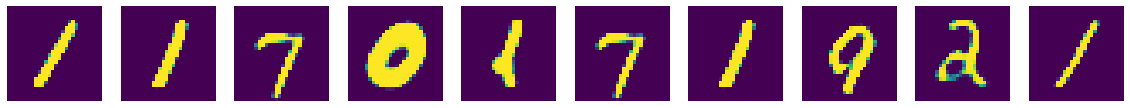

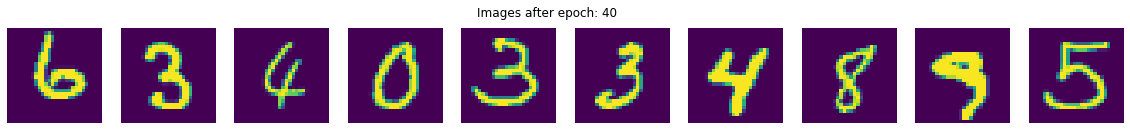

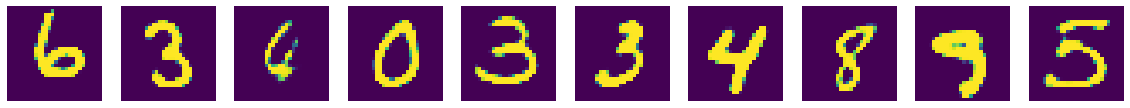

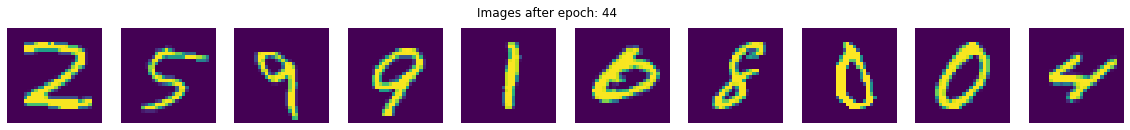

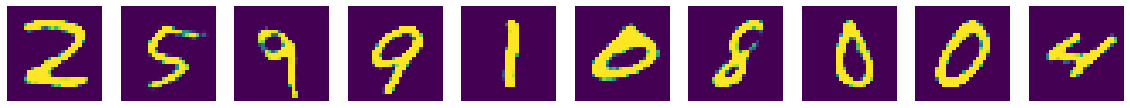

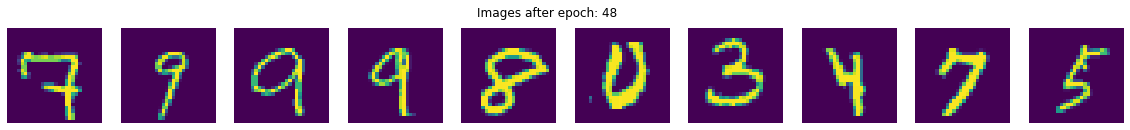

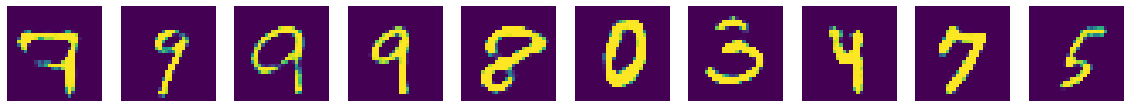

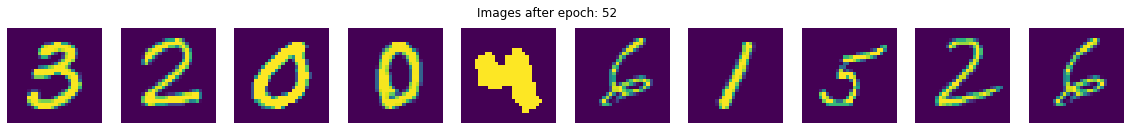

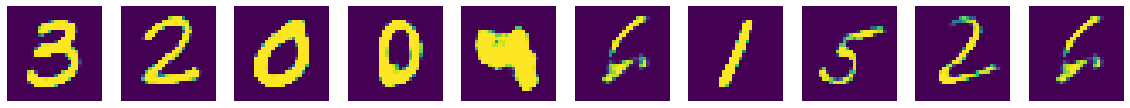

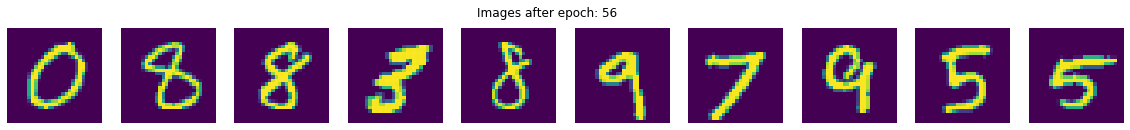

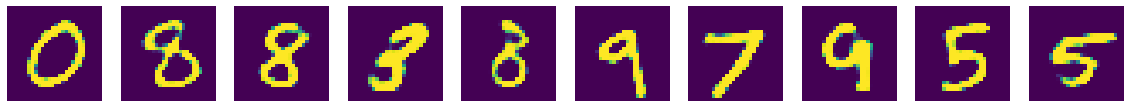

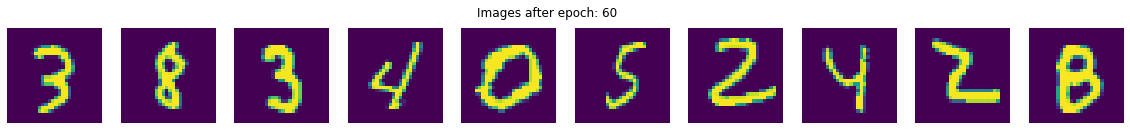

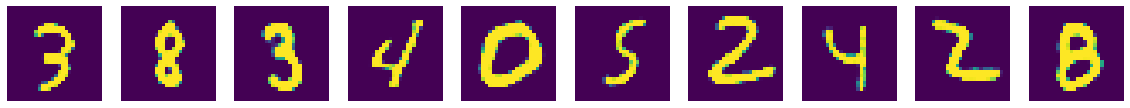

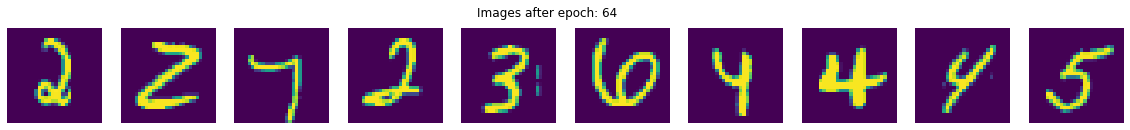

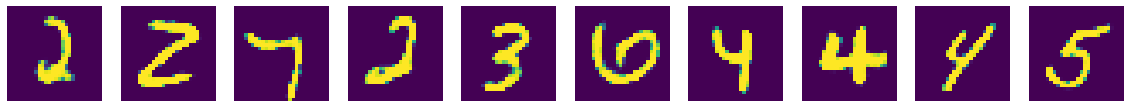

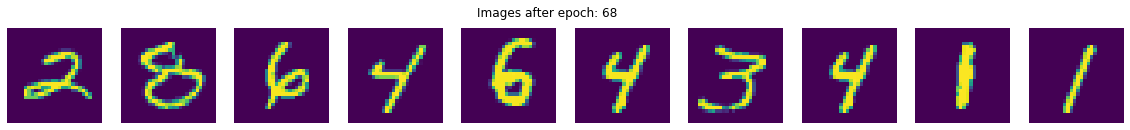

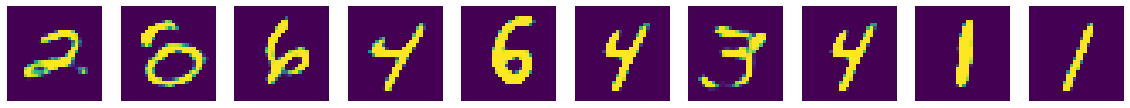

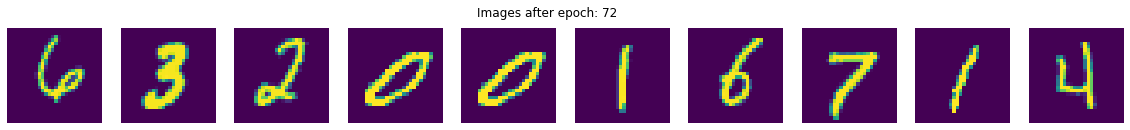

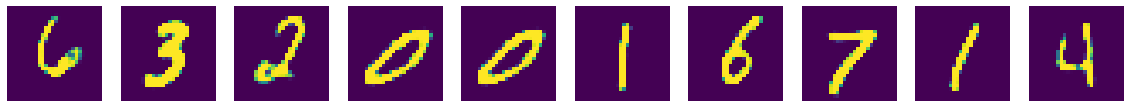

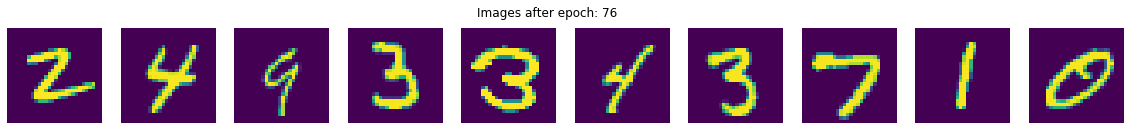

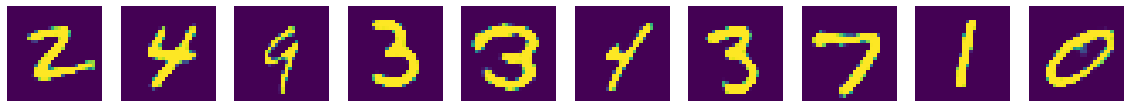

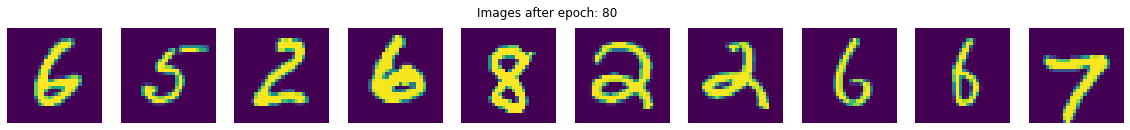

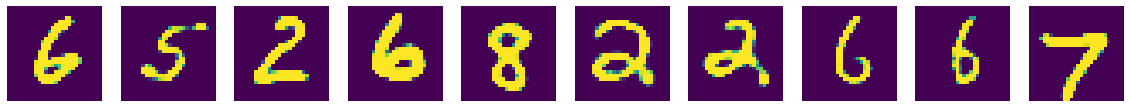

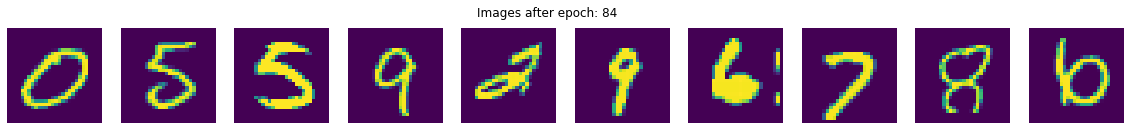

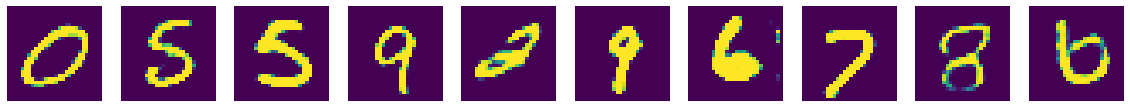

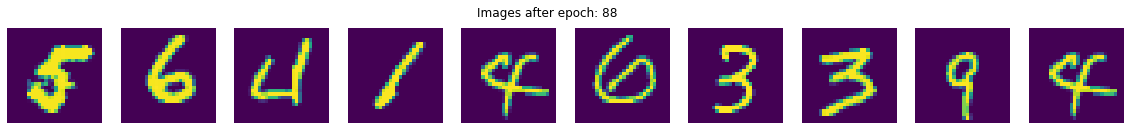

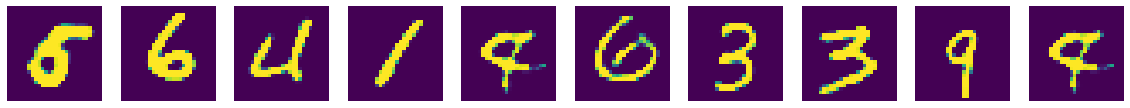

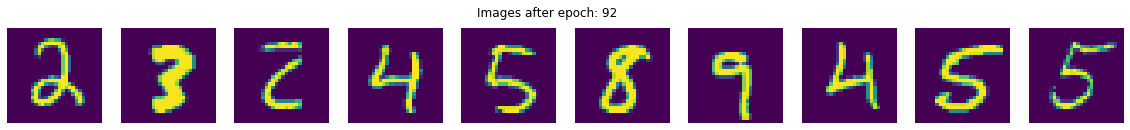

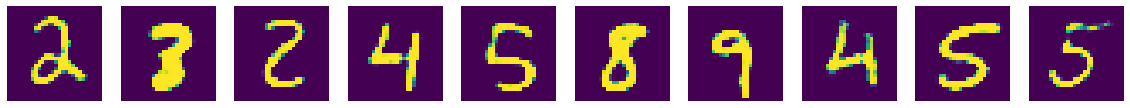

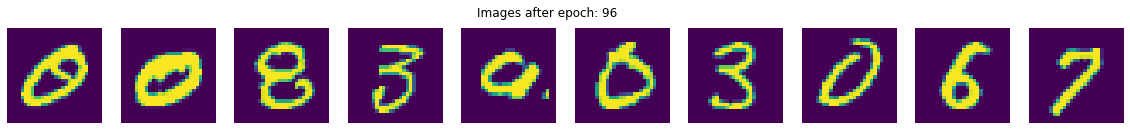

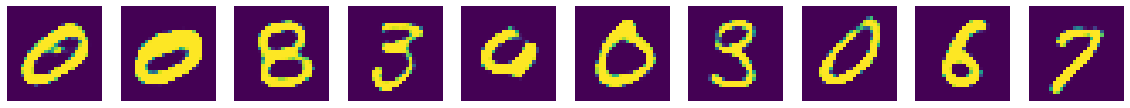

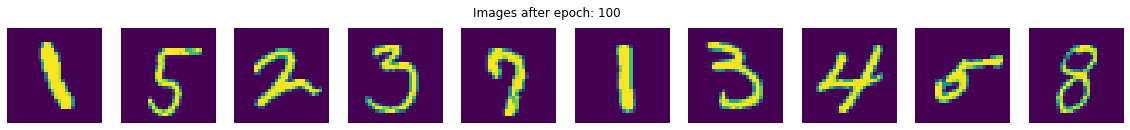

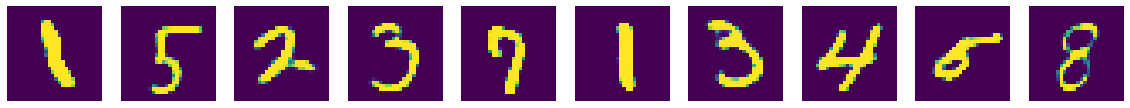

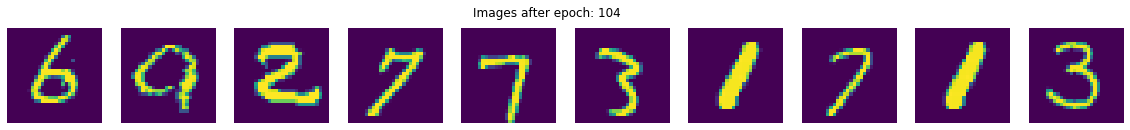

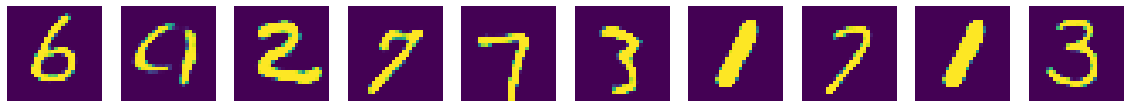

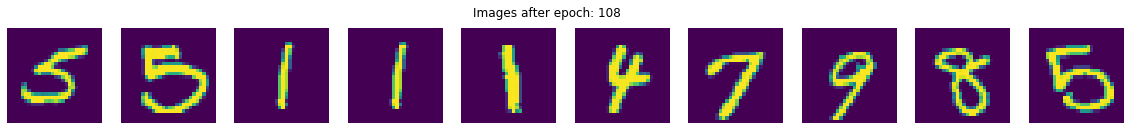

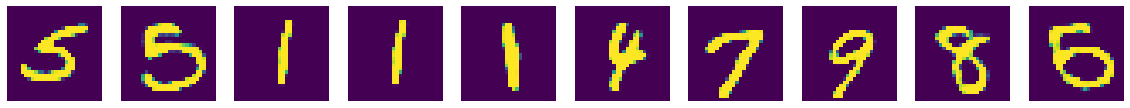

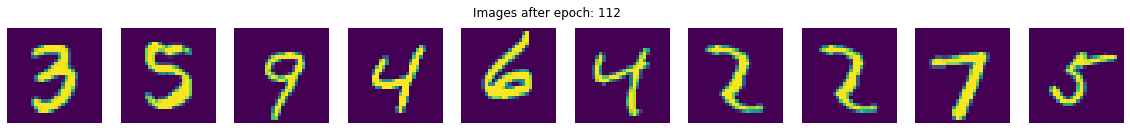

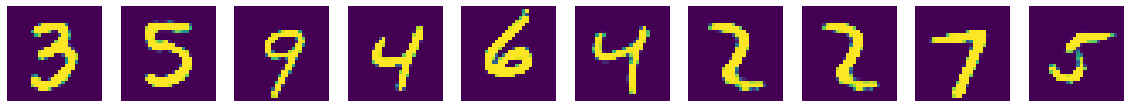

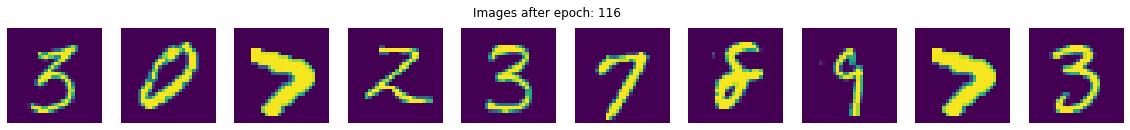

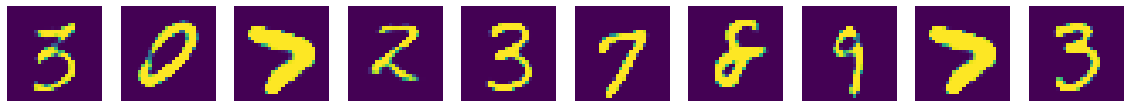

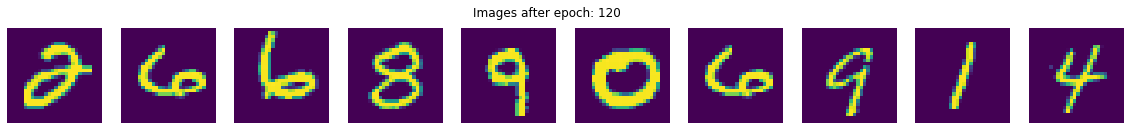

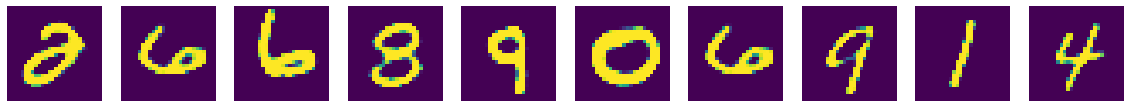

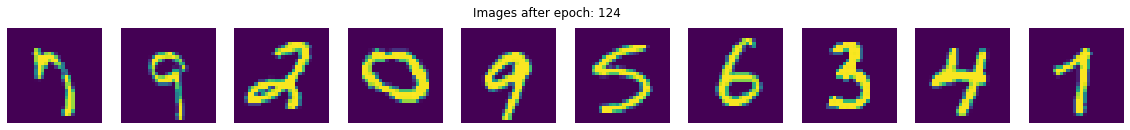

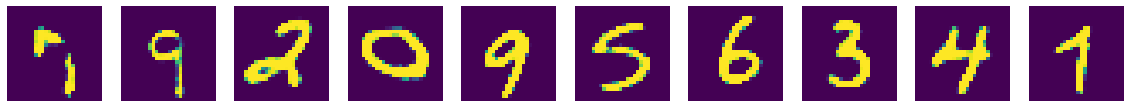

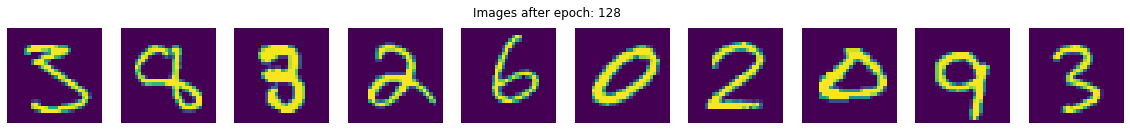

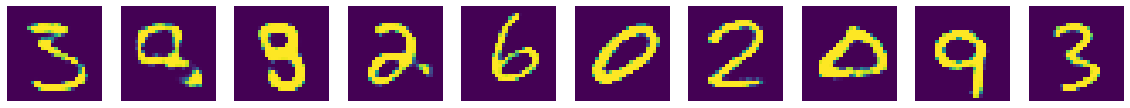

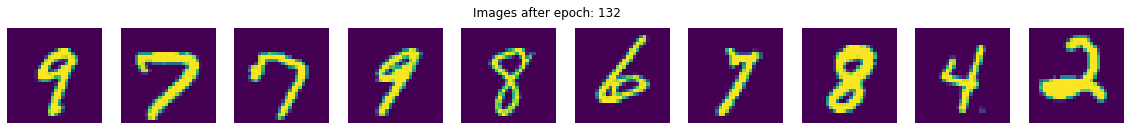

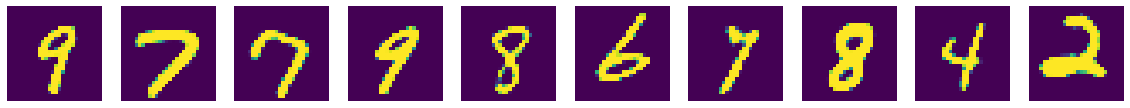

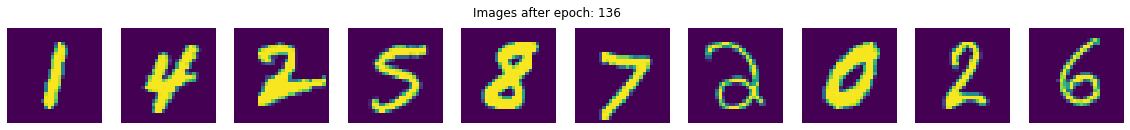

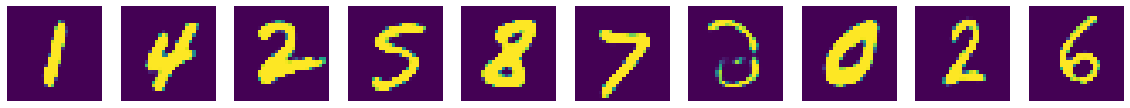

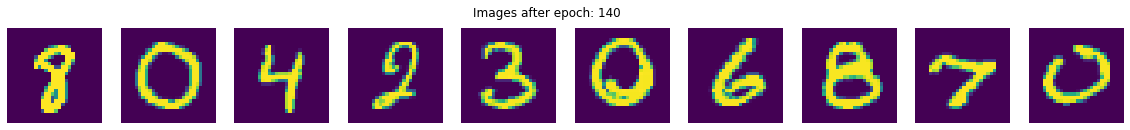

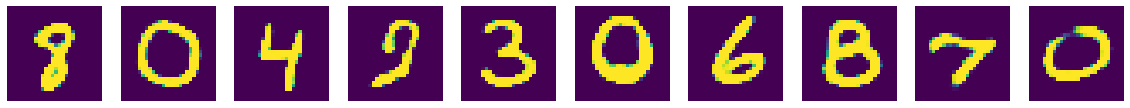

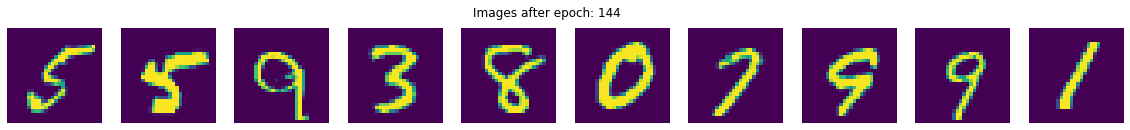

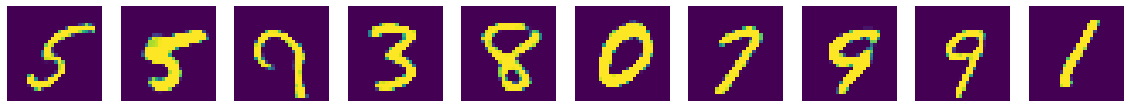

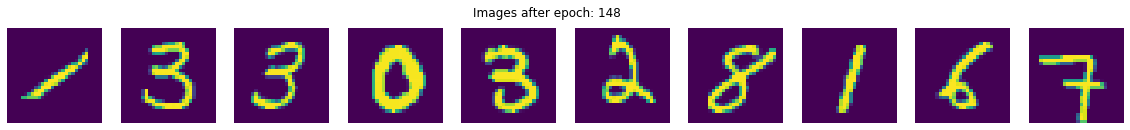

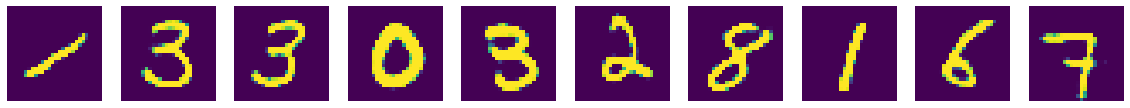

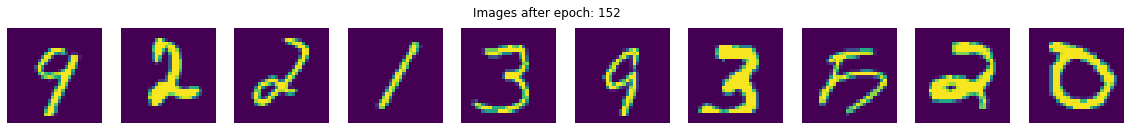

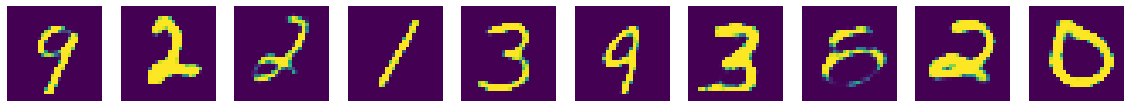

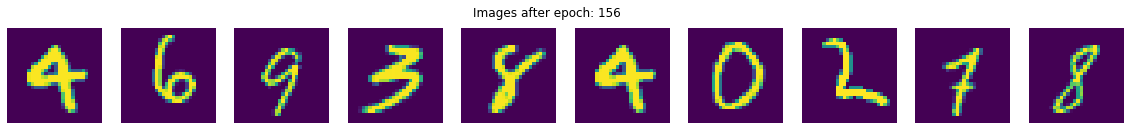

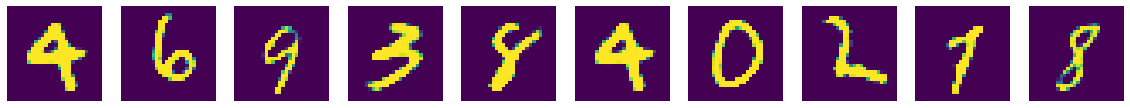

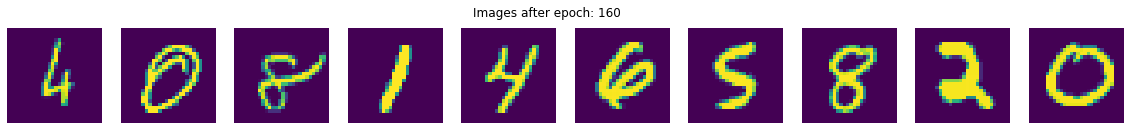

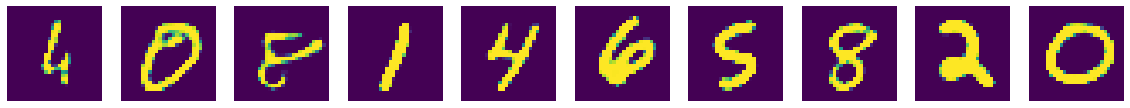

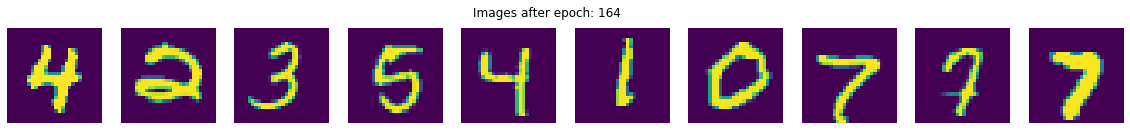

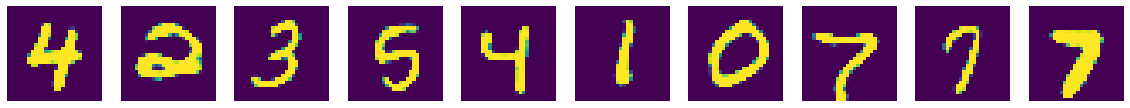

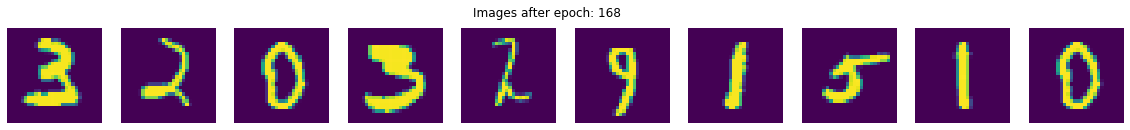

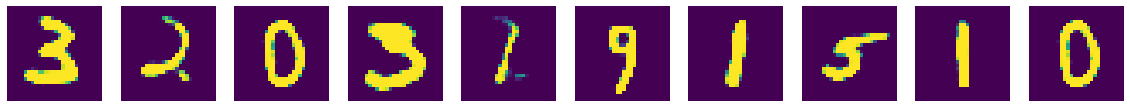

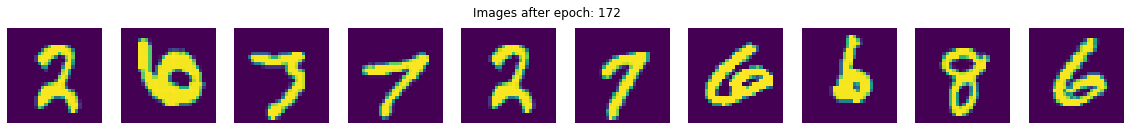

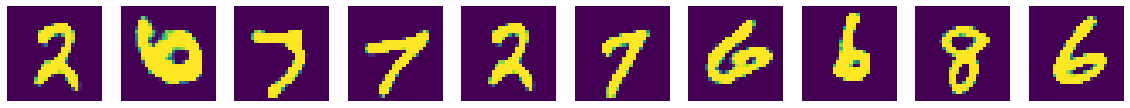

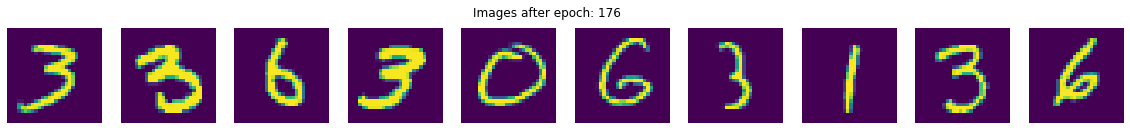

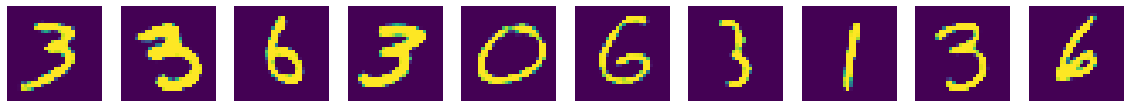

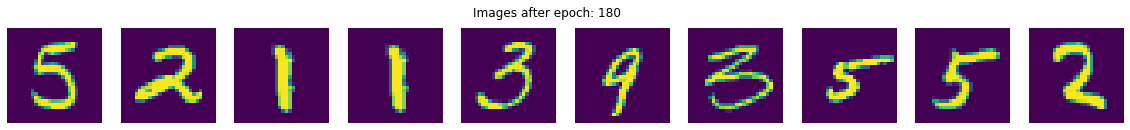

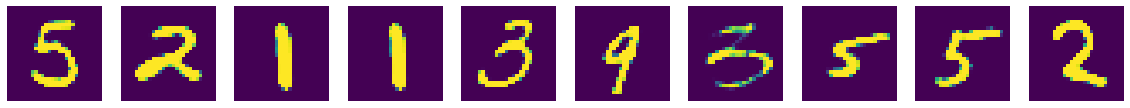

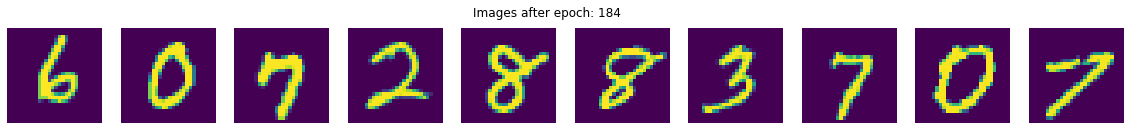

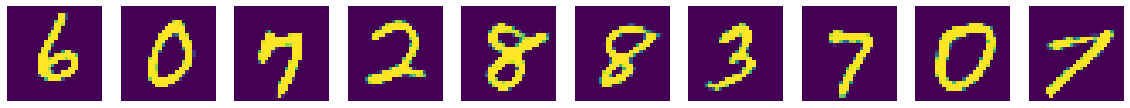

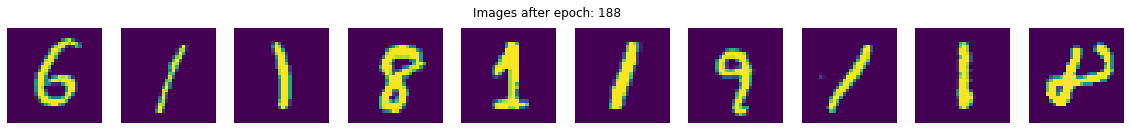

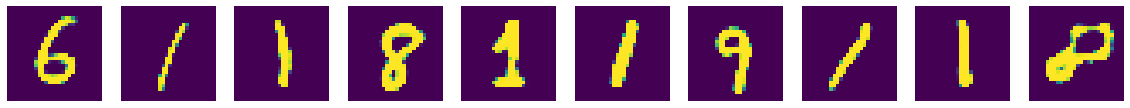

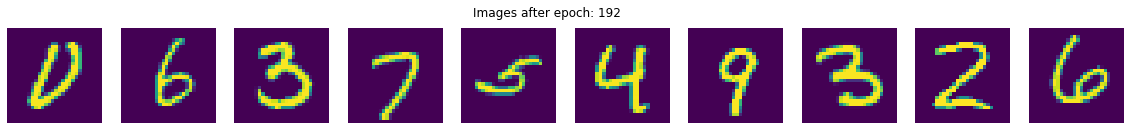

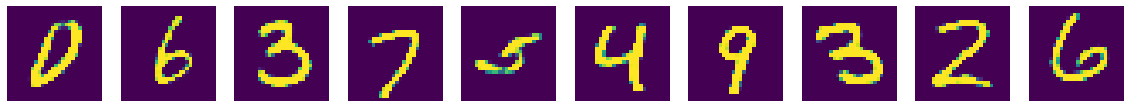

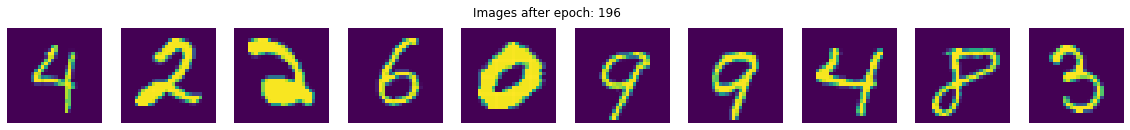

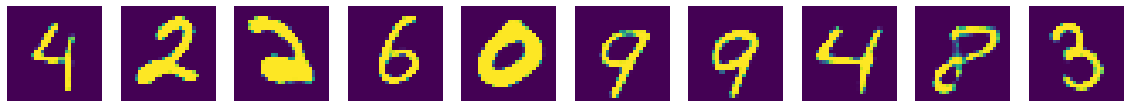

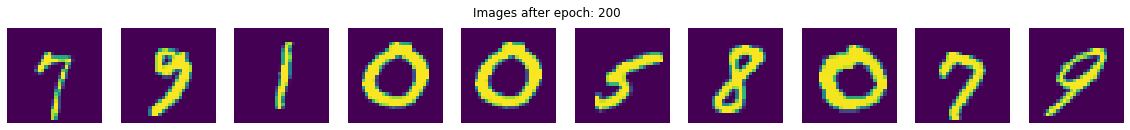

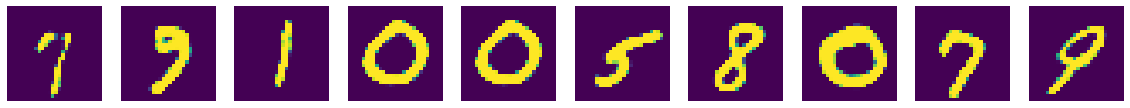

In [9]:
# plot reconstructions
plt.rcParams.update({'font.size': 10})
imx, imy = (28,28)
for i, imgs in enumerate(measures['recon_images']):
    fig, axs = plt.subplots(1, n_classes, figsize=(20,2)) 
    for j, img in enumerate(measures['true_images'][i]):
        axs[j].imshow(img)
        axs[j].axis('off')
    label = i+1 if i==0 else 4*i
    plt.suptitle('Images after epoch: %s' %label)        
    plt.show()        
    
    fig, axs = plt.subplots(1, n_classes, figsize=(20,2)) 
    for j, img in enumerate(imgs):
        visual = np.reshape(img, (imx,imy))
        axs[j].imshow(visual)
        axs[j].axis('off')
    plt.show()

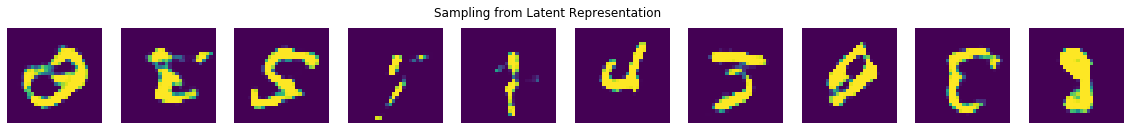

In [10]:
# Sample from latent and visualise
with torch.no_grad():
    vae.eval()
    samples = vae.sample(num_samples)

imx, imy = (28,28)
plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(1, num_samples, figsize=(20,2)) 
for j, img in enumerate(samples):
    visual = np.reshape(img, (imx,imy))    
    axs[j].imshow(visual)
    axs[j].axis('off')
plt.suptitle('Sampling from Latent Representation')        
plt.show()  